In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tqdm import tqdm

df = pd.read_csv('../data/graph_train.csv')
print(df[['graph_id', 'benchmark']].head())
y = pd.cut(df['edge_cross_norm'], bins=[-1,-1e-10,1]).to_numpy()
df = df.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','Unnamed: 0'],axis=1)
list_columns = list(df)

for col in list_columns:
    print(col)
    if col!= 'edge_cross_norm' and col!= 'is_bridge':
        df[col] = pd.qcut(df[col],q=5)

X = df.to_numpy()

classifier = XGBClassifier()
classifier.load_model('xgb.bin')

   graph_id   benchmark
0         0  random-dag
1         0  random-dag
2         0  random-dag
3         0  random-dag
4         0  random-dag
edge_betweenness
stress
is_bridge
diff_stress
diff_cross
diff_edgelength
exp_factor_norm
sum_neighbour_deg_norm
max_neighbour_deg_norm
grad_diff


In [11]:
from src.graph_parser import parseGraphmlFile
import os

def read_list_of_graphs(dir_name,ext):
    list_graphs = [parseGraphmlFile(dir_name+f,weighted=False,directed=False) for f in os.listdir(dir_name) if f.endswith('.' + ext)]
    return list_graphs

graph_lists = {
    'random-dag': read_list_of_graphs(f'../data/random-dag/','graphml'),
    'rome': read_list_of_graphs(f'../data/rome/','graphml'),
    'north': read_list_of_graphs(f'../data/north/','graphml')
}

In [147]:
from src.graph_utils import compareGraphs
import networkx as nx


def compareRelaxedDrawing(graph_id, bench, classifier, draw_f, thresh=0.5, num_edges=None, debug=False, blocked_edges=None, rm_edges=None):

    if blocked_edges is None:
        blocked_edges = []
    
    if rm_edges is None:
        rm_edges = []

    g = graph_lists[bench][graph_id]
    pos1 = draw_f(g)

    g_df = pd.read_csv('../data/graph_train.csv')
    g_df = g_df[(g_df.graph_id == graph_id) & (g_df.benchmark == bench)].reset_index(drop=True)
    g_df = g_df.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','Unnamed: 0','diff_cross'],axis=1)
    #print(g_df.columns)
    y_pred = classifier.predict_proba(g_df.to_numpy())[:, 1]
    if num_edges != None:
        edges_max_prob = np.argsort(y_pred)[-num_edges:]
        edges2rm = [e for e in edges_max_prob if (y_pred[e] > thresh and e not in blocked_edges)]
    else:  
        edges2rm = np.where(y_pred>thresh)[0]
        edges2rm = [e for e in edges2rm if e not in blocked_edges]
    edges2rm.extend(rm_edges)
    g_copy = g.copy()
    g_copy.remove_edges_from([list(g.edges())[idx] for idx in edges2rm])

    pos2 = draw_f(g_copy)

    if debug:
        print(f"Removed edges: {len(edges2rm)}")

    return compareGraphs(g, g, pos1, pos2, show=debug, rmedges=[list(g.edges())[idx] for idx in edges2rm]), edges2rm


Index(['edge_betweenness', 'stress', 'is_bridge', 'diff_stress',
       'diff_edgelength', 'exp_factor_norm', 'sum_neighbour_deg_norm',
       'max_neighbour_deg_norm', 'grad_diff'],
      dtype='object')
Removed edges: 2
           Num crossings: 6 - 3 (✅ -3.0)
            Aspect ratio: 0.890 - 0.612 (❌ -0.278)
     Mean crossing angle: 60.476 - 75.206 (✅ 14.730)
Pseudo vertex resolution: 0.276 - 0.189 (❌ -0.088)
 Mean angular resolution: inf - inf (🟡 nan)


/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/src/graph_utils.py:422: RuntimeWarning: invalid value encountered in subtract
  v = np.array(q2) - np.array(q1)


array([-3.        , -0.27775141, 14.73014257, -0.08792554,         nan,
       -0.07023381,  0.02068187])

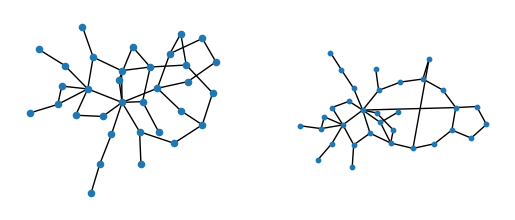

In [13]:
draw_f = lambda gg: nx.kamada_kawai_layout(gg, pos=nx.spectral_layout(gg))
compareRelaxedDrawing(3, 'rome', classifier, draw_f, debug=True, thresh=0.7)


In [24]:
from IPython.utils import io

n = 100
thresh_vals = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
thresh_labels = [f'thresh_{val}' for val in thresh_vals]

values = []

for graph_id in tqdm(range(n)):
    with io.capture_output() as captured:
        row = []
        for thresh in thresh_vals:
            cross_val = compareRelaxedDrawing(graph_id, 'rome', classifier, draw_f, debug=False, thresh=thresh)[0][0]
            row.append(cross_val)
        values.append(row)

values = pd.DataFrame(values, columns=thresh_labels)

values

100%|██████████| 100/100 [03:33<00:00,  2.13s/it]


,thresh_0.3,thresh_0.4,thresh_0.5,thresh_0.6,thresh_0.7,thresh_0.8,thresh_0.9,thresh_0.95
0,-38.0,14.0,4.0,4.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-3.0,10.0,9.0,0.0,0.0,0.0,0.0,0.0
3,-4.0,23.0,9.0,-1.0,-3.0,0.0,0.0,0.0
4,-6.0,25.0,8.0,7.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
95,-9.0,-11.0,-2.0,1.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,-48.0,23.0,-4.0,0.0,0.0,0.0,0.0,0.0
98,-5.0,-5.0,-2.0,0.0,0.0,0.0,0.0,0.0


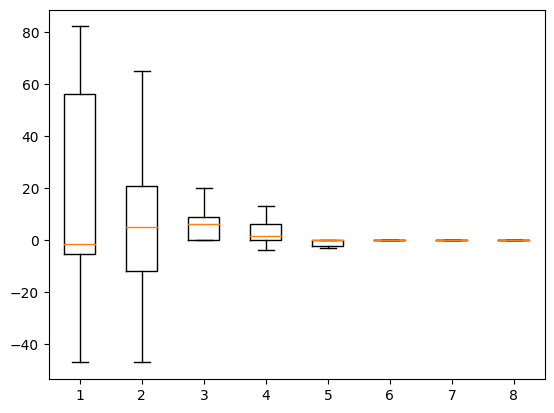

In [17]:
plt.boxplot(values, showfliers=False);

In [18]:
np.mean(values)

/Users/raulhigueras/Desktop/Research/EdgeRelaxationGraphDrawing/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


thresh_0.3     33.1
thresh_0.4      5.0
thresh_0.5     -3.4
thresh_0.6      3.0
thresh_0.7     -1.5
thresh_0.8     -2.6
thresh_0.9      0.0
thresh_0.95     0.0
dtype: float64

## Just Relaxing One

In [78]:
n = 100
values = []
edges_rm = []

for graph_id in tqdm(range(n)):
    with io.capture_output() as captured:
        diff_metrics, removed_edges  = compareRelaxedDrawing(graph_id, 'random-dag', classifier, draw_f, debug=False, num_edges=1)
        cross_val = diff_metrics[0]
        edges_rm.append(len(removed_edges))
        values.append(cross_val)

100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


In [71]:
changed_vals = [val for val, num in zip(values, edges_rm) if num > 0]
#plt.hist(values), np.median(values)
idx = np.argmin(values)


-32.0

Removed edges: 1
           Num crossings: 263 - 231 (✅ -32.0)
            Aspect ratio: 0.963 - 0.929 (❌ -0.034)
     Mean crossing angle: 59.551 - 61.059 (✅ 1.508)
Pseudo vertex resolution: 0.255 - 0.269 (✅ 0.014)
 Mean angular resolution: 35.459 - 37.244 (✅ 1.785)


(array([-3.20000000e+01, -3.40250029e-02,  1.50838947e+00,  1.37785865e-02,
         1.78548154e+00,  1.46333758e-02,  2.50592624e-03]),
 1)

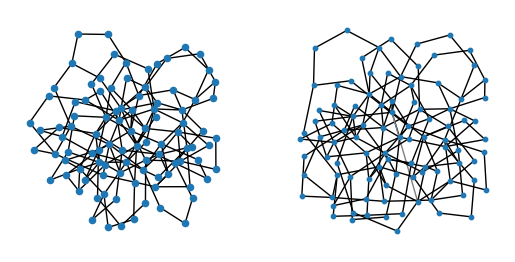

In [77]:
compareRelaxedDrawing(idx, 'random-dag', classifier, draw_f, debug=True, num_edges=1)

# Relaxing-Recomputing

In [86]:
from src.graph_utils import stress, total_stress, num_crossings, mean_edge_length, nodes_dict_to_array, distance_matrix
from src.graph_utils import gradient_kamada_kawai, max_neighbour_degrees_norm, sum_neighbour_degrees_norm, expansion_factor_norm, edge_crossings_norm
from src.graph_utils import max_j_node_centrality, sum_j_node_centrality, j_node_centrality

def getGraphDataForTest(graph: nx.Graph, draw_f, idx_graph:int, bench: str):
    data = []

    # Run Spectral +  Kamada-Kawai
    pos0 = draw_f(graph)

    # Compute general graph attributes
    eb = nx.edge_betweenness(graph)     # edge betweenness
    st = stress(graph, pos0)             # stress
    cross0 = -1#num_crossings(graph, pos0) 
    edgel0 = mean_edge_length(graph, pos0)
    total_stress0 = total_stress(graph, pos0)
    #deg = nx.degree(graph, graph.nodes)
    bridges = nx.bridges(graph)
    d0 = distance_matrix(graph)

    for idx_edge, e in enumerate(graph.edges):
        n1, n2 = e
        
        # New position removing edge
        graph_copy = graph.copy()
        graph_copy.remove_edges_from([e])
        pos1 = nx.kamada_kawai_layout(graph_copy,pos=pos0)
        pos1_arr = nodes_dict_to_array(pos1)
        pos0_arr = nodes_dict_to_array(pos0)
        cross1 = -1#num_crossings(graph, pos1) 
        edgel1 = mean_edge_length(graph, pos1)
        total_stress1 = total_stress(graph, pos1)
        #deg = nx.degree(graph, graph.nodes)
        exp_factor_norm = expansion_factor_norm(pos0_arr,pos1_arr)
        edge_cross_norm = -1#edge_crossings_norm(cross0-cross1, len(graph_copy.edges))
        d1 = distance_matrix(graph_copy)
        grad_diff = np.linalg.norm(gradient_kamada_kawai(pos0_arr,d0)-gradient_kamada_kawai(pos1_arr,d1))
        # Extra attributes
        max_deg = -1#max(deg[n1], deg[n2])
        min_deg = -1#min(deg[n1], deg[n2])
        sum_neighbour_deg_norm = sum_neighbour_degrees_norm(graph_copy,e)
        max_neighbour_deg_norm = max_neighbour_degrees_norm(graph_copy,e)
        #max_jnc = max_j_node_centrality(graph_copy,pos1_arr,e)
        #sum_jnc = sum_j_node_centrality(graph_copy,pos1_arr,e)
        nnodes, nedges = len(graph.nodes), len(graph.edges)
        
        row = [idx_graph, idx_edge, nnodes, nedges, eb[e], st[e], max_deg, min_deg, e in bridges,
            total_stress0 - total_stress1, cross0 - cross1, edgel0 - edgel1,
            bench, exp_factor_norm, edge_cross_norm, sum_neighbour_deg_norm, max_neighbour_deg_norm, grad_diff]
        data.append(row)

    cols = ['graph_id', 'edge_id', 'num_nodes', 'num_edges', 'edge_betweenness', 'stress', 'max_deg', 'min_deg', 'is_bridge', 'diff_stress', 'diff_cross', 'diff_edgelength', 'benchmark', 'exp_factor_norm', 'edge_cross_norm', 'sum_neighbour_deg_norm', 'max_neighbour_deg_norm', 'grad_diff']
    #                                                        'edge_betweenness', 'stress',                       'is_bridge', 'diff_stress',               'diff_edgelength',              'exp_factor_norm',                    'sum_neighbour_deg_norm', 'max_neighbour_deg_norm', 'grad_diff']
    df = pd.DataFrame(data, columns=cols)

    df = df.drop(labels=['edge_cross_norm','edge_id','graph_id','num_nodes','num_edges','benchmark','max_deg','min_deg','diff_cross'],axis=1)
    
    return df

def compareRelaxedDrawingFromGraph(g, classifier, draw_f, thresh=0.5, num_edges=None, debug=False):
    pos1 = draw_f(g)

    g_df = getGraphDataForTest(g, draw_f, 0, 'any')
    #print(g_df.columns)
    y_pred = classifier.predict_proba(g_df.to_numpy())[:, 1]
    if num_edges != None:
        edges_max_prob = np.argsort(y_pred)[-num_edges:]
        edges2rm = [e for e in edges_max_prob if y_pred[e] > thresh]
    else:  
        edges2rm = np.where(y_pred>thresh)[0]
    g_copy = g.copy()
    g_copy.remove_edges_from([list(g.edges())[idx] for idx in edges2rm])

    pos2 = draw_f(g_copy)

    if debug:
        print(f"Removed edges: {len(edges2rm)}")

    return compareGraphs(g, g, pos1, pos2, show=debug, rmedges=[list(g.edges())[idx] for idx in edges2rm]), edges2rm

In [89]:
from IPython.utils import io

n = 100
max_num_of_recomp = 10
bench = 'random-dag'
values = []

for graph_id in tqdm(range(n)):
    with io.capture_output() as captured:
        g = graph_lists[bench][graph_id].copy()
        row = [0 for _ in range(max_num_of_recomp)]
        for recomp in range(max_num_of_recomp):
            diff_metrics, edges2rm = compareRelaxedDrawingFromGraph(g, classifier, draw_f, debug=False, num_edges=1)
            if len(edges2rm) == 0:
                break
            cross_val = diff_metrics[0]
            row.append(cross_val)

            g.remove_edges_from([list(g.edges())[idx] for idx in edges2rm])

        values.append(row)

#values = pd.DataFrame(values, columns=thresh_labels)

#values

100%|██████████| 100/100 [4:57:52<00:00, 178.73s/it] 


ValueError: 8 columns passed, passed data had 10 columns

In [94]:
values
values_cum = [np.cumsum(row) for row in values]
values_best = [np.min(row) for row in values_cum]
np.mean(values_best)

-4.52

(array([ 2.,  2.,  2.,  7.,  7., 14., 28., 26., 10.,  2.]),
 array([-35. , -30.1, -25.2, -20.3, -15.4, -10.5,  -5.6,  -0.7,   4.2,
          9.1,  14. ]),
 <BarContainer object of 10 artists>)

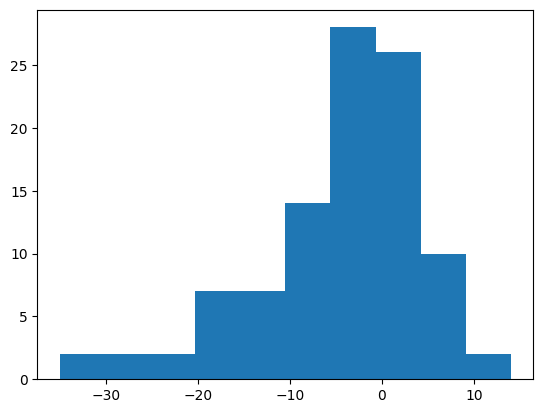

In [95]:
plt.hist(values_best)

## Relaxing-Blocking

In [130]:
def bfs_on_edges(g: nx.Graph, edge: list|tuple, depth_limit) -> list:
    bfs_edges = {edge}
    sp = dict(nx.all_pairs_shortest_path_length(g))
    for e in nx.edge_bfs(g, edge[0]):
        if sp[e[0]][edge[0]] == depth_limit+1 or sp[e[1]][edge[0]] == depth_limit+1:
            break
        bfs_edges.add(e)
    
    for e in nx.edge_bfs(g, edge[1]):
        if sp[e[0]][edge[1]] == depth_limit+1 or sp[e[1]][edge[1]] == depth_limit+1:
            break
        bfs_edges.add(e)

    return list(bfs_edges)

In [153]:
from IPython.utils import io

n = 100
max_num_relax = 20
bench = 'random-dag'
values_relax_blocking = []

for graph_id in tqdm(range(n)):
    #with io.capture_output() as captured:
    g = graph_lists[bench][graph_id].copy()
    edge2idx = {e:idx for idx, e in enumerate(g.edges())}
    for e, idx in list(edge2idx.items()):
        edge2idx[(e[1], e[0])] = idx
    row = [0.0 for _ in range(max_num_relax)]
    blocked_edges = set()
    rm_edges = [] 
    for i in range(max_num_relax):
        diff_metrics, edges2rm = compareRelaxedDrawing(graph_id, bench, classifier, draw_f, debug=False, num_edges=1, blocked_edges=blocked_edges, rm_edges=rm_edges)

        if set(edges2rm) == set(rm_edges):
            break
        
        rm_edges.append(edges2rm[0])
        cross_val = diff_metrics[0]
        row[i] = cross_val

        # Block neighbours of relax
        # print(edge2idx.keys())
        edges2block = [edge2idx[e] for e in bfs_on_edges(g, list(g.edges())[edges2rm[0]], 3)]
        blocked_edges |= set(edges2block)
        

    values_relax_blocking.append(row)

#values_relax_blocking = pd.DataFrame(values_relax_blocking, columns=[f'col_{i}' for i in range(max_num_relax)])

values_relax_blocking

100%|██████████| 100/100 [00:57<00:00,  1.75it/s]


[[-4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [-1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [5.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [-10.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [-12.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [-8.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [-4.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 [2.0

In [152]:
values_relax_blocking
values_relax_blocking_best = [np.min(row) for row in values_relax_blocking]
np.mean(values_relax_blocking_best)

-3.7

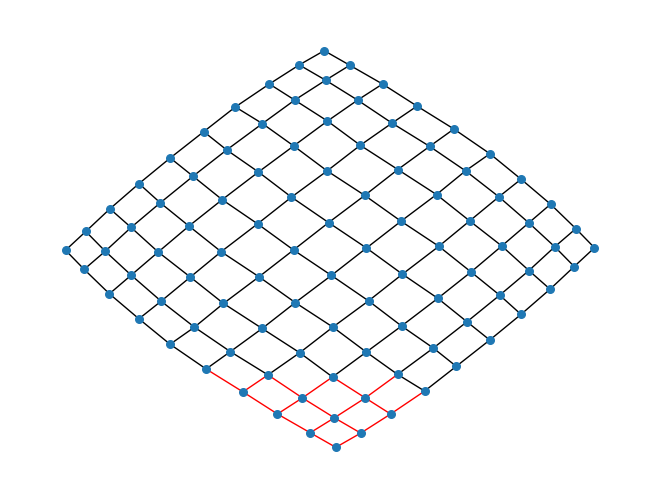

In [129]:
g = nx.grid_2d_graph(10, 10)

bfs_edges = bfs_on_edges(g, ((0,0),(0,1)), 3)

e_col = ['red' if (e in bfs_edges or e[::-1] in bfs_edges) else 'black' for e in g.edges]

nx.draw(g, nx.spring_layout(g, pos = nx.spectral_layout(g)), node_size=30, edge_color=e_col)